In [29]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [30]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

### Let's merge in Gene Expression level information into our gene annotation DataFrame 

In [33]:
rsem_df = pd.read_csv("merged_TPM_genes.tsv",sep="\t")[["Id","rsem.out.S442_NT"]]
# genes_Df  overlap   rsem
# ~4_300     ~23_200   ~2_500

In [34]:
genes_exp_df = pd.merge(
    rsem_df,
    genes_df,
    how = 'inner',
    left_on="Id",
    right_on="geneName"
)
genes_exp_df.head(3)

,Id,rsem.out.S442_NT,geneId,chr,txStart,txEnd,geneName,citationCount,strand,union_geneId,geneType,geneDesc,cdsStart,cdsEnd,exonStarts,exonEnds
0,C9orf152,0,401546,chr9,112961844,112970439,C9orf152,5,-,union_401546,protein-coding,chromosome 9 open reading frame 152,112963227,112969859,"112961844,112969666","112963754,112970439"
1,RPS11,4520,6205,chr19,49999690,50002965,RPS11,149,+,union_6205,protein-coding,ribosomal protein S11,49999713,50002892,"49999690,50000450,50000776,50001173,50002768","49999728,50000582,50000852,50001303,50002965"
2,ELMO2,14,63916,chr20,44994683,45035690,ELMO2,47,-,union_63916,protein-coding,engulfment and cell motility 2,44995998,45017838,"44994683,44994689,44997529,44999081,44999990,4...","44996199,44996199,44997607,44999164,45000098,4..."


In [35]:
# columns needed for TSS/TTS bed files output:
tx_cols = ["chr", "txStart", "txEnd", "strand", "rsem.out.S442_NT"]

tx_cols_rename = {"chr":"chrom",
                  "txStart":"start",
                  "txEnd":"end",
                  "rsem.out.S442_NT":"exp"}

gdf =  genes_exp_df[tx_cols].reset_index(drop=True).rename(tx_cols_rename,axis=1)

gdf["size"] = gdf["end"] - gdf["start"]

In [36]:
gdf = gdf.sort_values(["chrom","start"])
gdf = gdf[gdf["chrom"].isin(autosomal_chroms)]
gdf = gdf.reset_index(drop=True)
gdf.head(3)

,chrom,start,end,strand,exp,size
0,chr1,11873,14409,+,0,2536
1,chr1,14361,29370,-,32,15009
2,chr1,69090,70008,+,0,918


In [40]:
# gdf.to_csv("annotated_genes_for_pileups.bed",sep="\t",index=False,header=None)

In [13]:
fig5_samples = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "ev1_CTCF",
                "ev1_noCTCF",
                "ev1_polII",
                "ev1_nopolII",
                "polII",
                'h3k4_r1',
                "mrna_ctcf",
                "mrna_noctcf"]

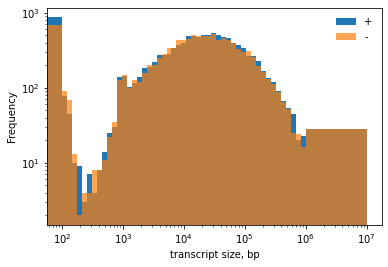

In [14]:
bins = np.r_[0,np.geomspace(100,1_000_000),10_000_000]
gdf[gdf["strand"]=="+"]["size"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["size"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("transcript size, bp")
ax.legend(frameon=False)

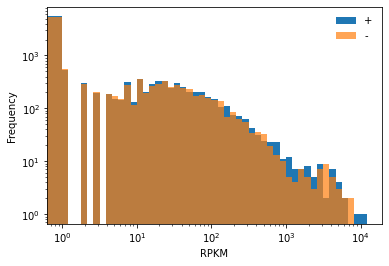

In [15]:
# actually - negative polarity genes are less expressed than tha positive strand genes ...
bins = np.r_[0,np.geomspace(1,12000)]
gdf[gdf["strand"]=="+"]["exp"].plot.hist(bins=bins,log=True,label="+")
gdf[gdf["strand"]=="-"]["exp"].plot.hist(bins=bins,log=True,alpha=0.7,label="-")
ax = plt.gca()
ax.set_xscale("log")
ax.set_xlabel("RPKM")
ax.legend(frameon=False)

In [16]:
exp_bin_edges = [0,1,10,np.inf]
exp_labels = ("no","low","high")
sizes_bin_edges = [0,50_000,np.inf]
sizes_labels = ("short","long")

gdf["gexp"] = pd.cut(
    gdf["exp"],
    bins = exp_bin_edges,
    labels = exp_labels,
    include_lowest = True
)
gdf["gsize"] = pd.cut(
    gdf["size"],
    bins = sizes_bin_edges,
    labels = sizes_labels,
    include_lowest = True
)
display(gdf.head())
display( gdf.groupby(["gexp","gsize"]).size().unstack(fill_value=0) )

,chrom,start,end,strand,exp,size,gexp,gsize
0,chr1,11873,14409,+,0,2536,no,short
1,chr1,14361,29370,-,32,15009,high,short
2,chr1,69090,70008,+,0,918,no,short
3,chr1,134772,140566,-,0,5794,no,short
4,chr1,562759,564389,-,0,1630,no,short


gsize,short,long
gexp,,
no,9492,2418
low,1842,1227
high,5035,2280


In [17]:
# extend the stacking region by the gene length on each side !
gdf["start"] = gdf["start"] - gdf["size"]
gdf["end"] = gdf["end"] + gdf["size"]

In [18]:
# 'ev1_CTCF', 'ev1_noCTCF', 'ev1_polII', 'ev1_nopolII'
def extract_ins(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    use "strand" information to flip "-" strand genes ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )[:: (1 if strand=="+" else -1) ] # flip in place for "-" genes
      for chrom, start, end, strand, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


def extract_ins_noflip(df,
                fname,
                bins=3000
               ):
    """
    for a BED-like DF, extract 'signal' from BW (fname) for every interval
    no flipping ...
    """
    return np.nanmean(np.asarray([
        bbi.fetch
               (
                    fname,
                    chrom,
                    start,
                    end,
                    bins=bins,
                    missing=0.0,
                    oob=np.nan,
                    summary='mean',
                )
      for chrom, start, end, *_ in df.itertuples(index=False)
    ]),
      axis=0,                
     )


In [19]:
ctcf_df = bioframe.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",schema="bed3",index_col=False)
# # ctcf_df = pd.read_table("intersect-all-NT-CTCF-NO-G4-centered-RAD21",header=None)
ctcf_df = ctcf_df.sort_values(["chrom","start"])
ctcf_df = ctcf_df[ctcf_df["chrom"].isin(autosomal_chroms)]
ctcf_df = ctcf_df.reset_index(drop=True)
ctcf_df["start"] = ctcf_df["start"] - 200_000
ctcf_df["end"] = ctcf_df["end"] + 200_000
ctcf_df.head(3)

,chrom,start,end
0,chr1,-189849,210508
1,chr1,604937,1005691
2,chr1,675596,1075897


### TSS to TTS scaled profiles ...

In [20]:
# key features/signals that we want to extract for our genes ...
key_features  = ["ins_CTCF",
                "ins_noCTCF",
                "ins_polII",
                "ins_nopolII",
                "Rloop_K562",
                "G4a_r2"]

### Extracting Meta-gene profiles of the key-features (insulations, Chip_Seq data etc)

#### Here we extract data for + and - genes separately and flip "-" genes to orient them same way as the "+" genes ...
#### using `extract_ins` function...

In [21]:
profiles_dict = {}

# group genes by expression and size before extracting corresponding profiles of a list of features :
gene_groups = gdf.groupby(["gexp","gsize"])
for feature_name in key_features:
    print(f"extracting {feature_name} for the genes ...")
    feature_fname = samples[feature_name]["fname"]
    profiles_dict[feature_name] = gene_groups.apply( lambda sub_df: extract_ins(sub_df, feature_fname) )

extracting ins_CTCF for the genes ...
extracting ins_noCTCF for the genes ...
extracting ins_polII for the genes ...
extracting ins_nopolII for the genes ...
extracting Rloop_K562 for the genes ...
extracting G4a_r2 for the genes ...


### CTCF insulation/Rloops profiles to match the scaled TSS/TTS profiles ...

#### In this case we are not flipping profiles according to orientation (yet), so we have to use `extract_ins_noflip` function

In [22]:
CTCF_profiles_dict = {}

for feature_name in key_features:
    print(f"extracting {feature_name} for the CTCF peaks ...")
    feature_fname = samples[feature_name]["fname"]
    CTCF_profiles_dict[feature_name] = extract_ins_noflip(ctcf_df, feature_fname, bins=300)

extracting ins_CTCF for the CTCF peaks ...
extracting ins_noCTCF for the CTCF peaks ...
extracting ins_polII for the CTCF peaks ...
extracting ins_nopolII for the CTCF peaks ...
extracting Rloop_K562 for the CTCF peaks ...
extracting G4a_r2 for the CTCF peaks ...


### Normalize insulation by subtracting average flanking signal

In [23]:
ins_keys = [k for k in key_features if k.startswith("ins") ]

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for CTCF-peak profiles ...")
    ins_profile = CTCF_profiles_dict[feature_name]
    flank_size = int(len(ins_profile)*0.25)
    # average left and right shoulders of `flank_size` ...
    average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
    # subtract that average flank ...
    CTCF_profiles_dict[feature_name] = CTCF_profiles_dict[feature_name] - average_signal_across_flank
    

for feature_name in ins_keys:
    print(f"normalizing insulation {feature_name} for gene profiles ...")
    for gexp_gsize_key, ins_profile in profiles_dict[feature_name].iteritems():
        flank_size = int(len(ins_profile)*0.25)
        # average left and right shoulders of `flank_size` ...
        average_signal_across_flank = np.nanmean(np.r_[ins_profile[:flank_size], ins_profile[-flank_size:]])
        # subtract that average flank ...
        profiles_dict[feature_name][gexp_gsize_key] = ins_profile - average_signal_across_flank


normalizing insulation ins_CTCF for CTCF-peak profiles ...
normalizing insulation ins_noCTCF for CTCF-peak profiles ...
normalizing insulation ins_polII for CTCF-peak profiles ...
normalizing insulation ins_nopolII for CTCF-peak profiles ...
normalizing insulation ins_CTCF for gene profiles ...
normalizing insulation ins_noCTCF for gene profiles ...
normalizing insulation ins_polII for gene profiles ...
normalizing insulation ins_nopolII for gene profiles ...


#### Plotting the profiles ...

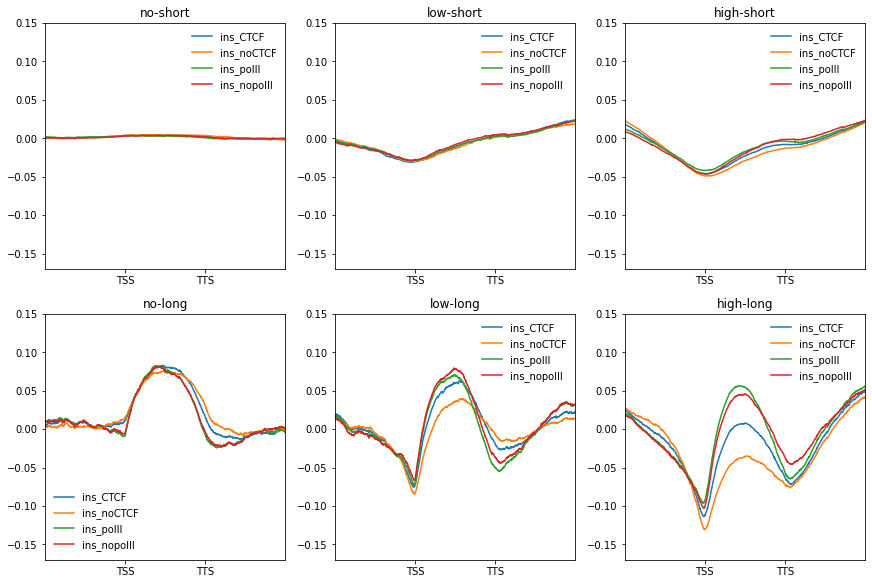

In [24]:
glens=("short","long")
gexps=("no","low","high")

fig = plt.figure(figsize=(12,8),constrained_layout=True)
gs = fig.add_gridspec(len(glens),len(gexps))

for i,glen in enumerate(glens):
    for j,gexp in enumerate(gexps):
        ax = fig.add_subplot(gs[i,j])
        for feature_name in ins_keys:
            ins_profiles = profiles_dict[feature_name]
            ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
        ax.set_title(f"{gexp}-{glen}")
        ax.legend(frameon=False)
        ax.set_ylim(-0.17,.15)
        ax.set_xlim(0,3000)
        ax.set_xticks([1000,2000])
        ax.set_xticklabels(["TSS","TTS"])

### Figure 3C itself ! comparing average insulation


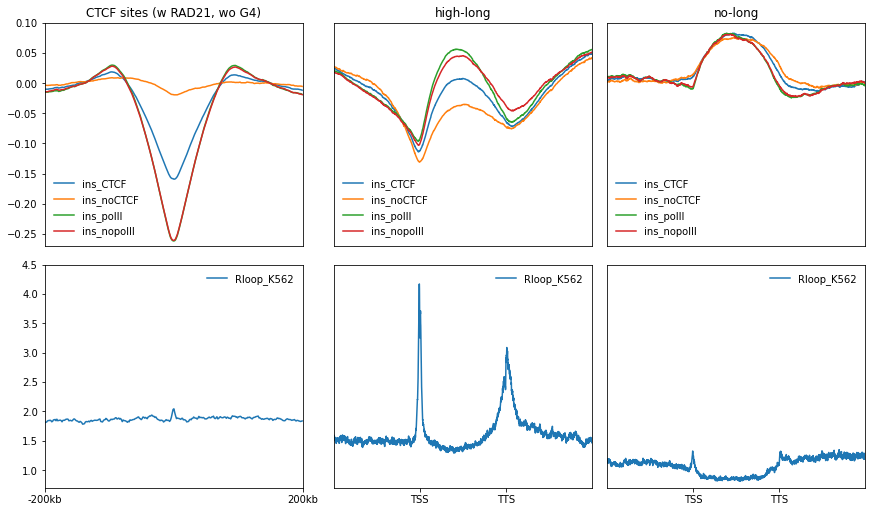

In [26]:
fig = plt.figure(figsize=(12,7),constrained_layout=True)
gs = fig.add_gridspec(2,3)

ins_keys_figure = ['ins_CTCF', 'ins_noCTCF', "ins_polII", 'ins_nopolII']

ins_ylim = (-0.27,.1)
rloop_ylim = (.7,4.5)


# insulation profiles around CTCF-peaks
ax = fig.add_subplot(gs[0,0])
for feature_name in ins_keys_figure:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.set_title(f"CTCF sites (w RAD21, wo G4)")
ax.legend(frameon=False)
ax.set_ylim(ins_ylim)
ax.set_xlim(0,300)
ax.set_xticks([])
ax.set_xticklabels([])

# insulation profiles around genes ...
glen="long"
gexps=("high","no")
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[0,j+1])
    for feature_name in ins_keys_figure:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.set_title(f"{gexp}-{glen}")
    ax.legend(frameon=False)
    ax.set_ylim(ins_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.set_yticks([])
    ax.set_yticklabels([])


# CTCF-peak based profiles ...

ax = fig.add_subplot(gs[1,0])
for feature_name in ["Rloop_K562",]:
    ins_profile = CTCF_profiles_dict[feature_name]
    ax.plot(ins_profile,label=feature_name)
ax.legend(frameon=False)
ax.set_ylim(rloop_ylim)
ax.set_xlim(0,300)
ax.set_xticks([0,300])
ax.set_xticklabels(["-200kb","200kb"])

# insulation profiles around genes ...
for j, gexp in enumerate(gexps):
    ax = fig.add_subplot(gs[1,j+1])
    for feature_name in ["Rloop_K562",]:
        ins_profiles = profiles_dict[feature_name]
        ax.plot(ins_profiles[(gexp,glen)],label=feature_name)
    ax.legend(frameon=False)
    ax.set_ylim(rloop_ylim)
    ax.set_xlim(0,3000)
    ax.set_xticks([1000,2000])
    ax.set_xticklabels(["TSS","TTS"])
    ax.set_yticks([])
    ax.set_yticklabels([])

# plt.savefig("Fig3C_withPolII.pdf")

In [27]:
# ! scp Fig3C_withPolII.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

Fig3C_withPolII.pdf                           100%  490KB 455.1KB/s   00:01    
